<a href="https://colab.research.google.com/github/guilhermebene/cyberlabs-mnist/blob/main/mnist_train2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization (run this part only if you are using Google Collaboratory)

Otherwise, skip to the next section (Imports).

In [1]:
!pip3 install torch torchvision torchaudio
!pip install matplotlib
!pip install numpy

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [3]:
import os
os.chdir('/content/gdrive/MyDrive/cyberlabs-mnist')

# Imports
For this problem we will use PyTorch and torchvision as the main libraries, since they are the ones I have been using lately. Numpy is also necessary for some mathematical manipulations as well as matplotlib for plots and graphs.

In [4]:
import time
import copy
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from matplotlib import pyplot as plt

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
torch.manual_seed(7)
batch_size = 128

Using device: cuda:0


# Data

## Creating Datasets

We will need to use some data augmention to get improve our results since the amount of actually useful images in MNIST is rather small due to my interpretation of the problem. This is better explained in the following cells.

In [6]:
CNN_transform = transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)), # Normalizing by the mean and std-dev of the entire dataset (as recommended by torchvision)
                transforms.GaussianBlur((3,3)),
                transforms.RandomAffine(degrees=10, translate=(0.2,0.2), scale=(0.8, 1.2))
                ]) 

In [7]:
mnist_path = Path('./mnist')

if not mnist_path.exists():
    mnist_path.mkdir()

mnist_trainset = datasets.MNIST(root=str(mnist_path.resolve()), train=True, download=True, transform=CNN_transform)
mnist_testset = datasets.MNIST(root=str(mnist_path.resolve()), train=False, download=True, transform=CNN_transform)

print(mnist_trainset)
print(mnist_testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/gdrive/MyDrive/cyberlabs-mnist/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
               RandomAffine(degrees=[-10.0, 10.0], translate=(0.2, 0.2), scale=(0.8, 1.2))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/gdrive/MyDrive/cyberlabs-mnist/mnist
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
               RandomAffine(degrees=[-10.0, 10.0], translate=(0.2, 0.2), scale=(0.8, 1.2)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
mnist_trainset.data.float().mean()/255
mnist_trainset.data.float().std()/255

tensor(0.3081)

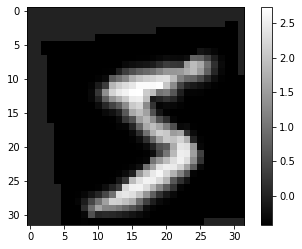

In [9]:
im,label = next(iter(mnist_trainset))
plt.imshow(im.squeeze(),cmap='gray')
plt.colorbar()

## Analyzing datasets

In this case we are dealing with a classification problem. We can think of 3 different classes: digit 0, digit 5 and all the other digits. We start by calculating the amount of samples in each one of them in the train set.

In [10]:
freq_0 = torch.sum(mnist_trainset.targets == 0).cpu().detach().numpy()
freq_5 = torch.sum(mnist_trainset.targets == 5).cpu().detach().numpy()
freq_other = torch.sum(torch.logical_not(torch.logical_or(mnist_trainset.targets == 0, mnist_trainset.targets == 5))).cpu().detach().numpy()

The next graph shows the frequencies for each class. As expected, there is too many examples in the "other digits" class, meaning the dataset is very imbalanced for our problem. Since the problem description is not very detailed, we can choose to train our solution to differentiate only between 0s and 5s, meaning by hypothesis every input will always be one of these two digits. In this case we can select only the necessary parts of the train and test sets.

A different solution for this problem would be to selectively augment the samples in the unbalanced classes in order to artificially balance the classes.

Moreover, it is important to note that even if we keep only os and 5s, the classes will still be umbalanced.

Frequencies:
Digit 0: 0.09871666666666666
Digit 5: 0.09035
Other digits: 0.8109333333333333


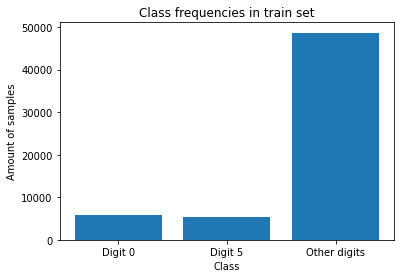

In [11]:
plt.bar(np.array(['Digit 0','Digit 5','Other digits']),np.array([freq_0,freq_5,freq_other]))
plt.xlabel('Class')
plt.ylabel('Amount of samples')
plt.title('Class frequencies in train set')

print('Frequencies:')
print(f'Digit 0: {freq_0/len(mnist_trainset)}')
print(f'Digit 5: {freq_5/len(mnist_trainset)}')
print(f'Other digits: {freq_other/len(mnist_trainset)}')

Here, we select the elements of the sets that are either 0 or 5, the resulting datasets are much smaller than initially. The total amount of data for train and test is rather small, which justifies the data augmention proposed in the dataset transform previously defined.

In [12]:
train_idx = torch.logical_or(mnist_trainset.targets == 0, mnist_trainset.targets == 5)
mnist_trainset.data = mnist_trainset.data[train_idx]
mnist_trainset.targets = mnist_trainset.targets[train_idx]

test_idx = torch.logical_or(mnist_testset.targets == 0, mnist_testset.targets == 5)
mnist_testset.data = mnist_testset.data[test_idx]
mnist_testset.targets = mnist_testset.targets[test_idx]

print(f'Trainset size: {len(mnist_trainset)}')
print(f'Testset size: {len(mnist_testset)}')

Trainset size: 11344
Testset size: 1872


## Defining the dataloaders

In [13]:
def collate_mnist(batch):
    modified_batch = []
    for item in batch:
        image, label = item
        if label == 0:
            label = 0
        
        if label == 5:
            label = 1
        
        item = image, label
        modified_batch.append(item)
    
    return torch.utils.data.dataloader.default_collate(modified_batch)

trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size, shuffle=True, collate_fn=collate_mnist)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size, shuffle=True, collate_fn=collate_mnist)

class_names = ['Class 0', 'Class 5']
dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train':len(mnist_trainset), 'val':len(mnist_testset)}

### Example of an image from MNIST

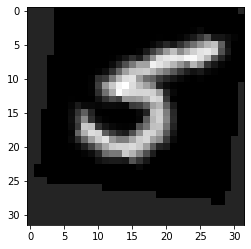

In [14]:
im,label = next(iter(trainloader))
plt.imshow(im[0,0,:,:],cmap='gray')

# Initial Classification model

The initial classification model used is rather simple. It is based on LeNet5, framwork developped by one of MNIST's creators.

The main idea behind it is to use a Convolutional Neural Network to extract features from the images, also named a feature extractor, and then feed the features to a classifier composed of fully connected layers that will decide whether an image represents the digit 0 or 5. 

The deeper the convolutional layer is, the "higher level" details it sees. More information about each layer is informed in the code block below.

In [15]:
class mnistClassifier(nn.Module):

  def __init__(self):
        super(mnistClassifier, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),  # 6 convolution filters of size 5x5                  
            nn.ReLU(), # ReLU activation function    
            nn.MaxPool2d(kernel_size=2),    
        )

        self.conv2 = nn.Sequential( 
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), # 16 convolution filters of size 5x5    
            nn.ReLU(), # ReLU activation function              
            nn.MaxPool2d(kernel_size=2),                
        )
        self.conv3 = nn.Sequential( 
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1), # 120 convolution filters of size 5x5
            nn.ReLU(), # ReLU activation function             
        )

        self.classifier = nn.Sequential(
            #  nn.Linear(in_features=120, out_features=84),
            #  nn.ReLU(), # ReLU activation function 
            #  nn.Linear(in_features=84, out_features=2),
            nn.Linear(in_features=120, out_features=2),  # Fully connected layer mapping all flattened features from the output of conv3 to 2 output classes. 
        )                                                # We could have used a single output class as well.

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      x = F.softmax(x)
      return x

In [16]:
model = mnistClassifier().to(device)

## Defining train parameters

In [17]:
epochs = 20
learning_rate = 1e-3
reg = 1e-7
step_size = 10
gamma = 0.2

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

## Defining useful functions for training

In [18]:
def checkpoint(root, epoch, model):
    """ Saves the dictionaries of a given pytorch model for 
        the right epoch
        """
    model_out_path = "model_epoch_{}.pth".format(epoch)
    model_out_path = root / model_out_path;
    torch.save(model.state_dict() , model_out_path);
    print("Checkpoint saved to {}".format(model_out_path))

def train_model(ckeckpoint_path, device, model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    val_acc = []
    train_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()
                train_acc.append(epoch_acc)

            if phase == 'val':
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        ckeckpoint_path = Path(ckeckpoint_path)

        if not ckeckpoint_path.exists():
          ckeckpoint_path.mkdir()

        checkpoint(ckeckpoint_path, epoch, model)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    plt.plot(np.arange(0,num_epochs), train_acc, label='Train accuracy')
    plt.plot(np.arange(0,num_epochs), val_acc, label='Test accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training the model

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 0.4308 Acc: 0.8837
val Loss: 0.3431 Acc: 0.9712
Checkpoint saved to checkpoints3/model_epoch_0.pth

Epoch 1/19
----------
train Loss: 0.3395 Acc: 0.9751
val Loss: 0.3447 Acc: 0.9696
Checkpoint saved to checkpoints3/model_epoch_1.pth

Epoch 2/19
----------
train Loss: 0.3342 Acc: 0.9797
val Loss: 0.3276 Acc: 0.9872
Checkpoint saved to checkpoints3/model_epoch_2.pth

Epoch 3/19
----------
train Loss: 0.3283 Acc: 0.9859
val Loss: 0.3338 Acc: 0.9792
Checkpoint saved to checkpoints3/model_epoch_3.pth

Epoch 4/19
----------
train Loss: 0.3272 Acc: 0.9858
val Loss: 0.3252 Acc: 0.9877
Checkpoint saved to checkpoints3/model_epoch_4.pth

Epoch 5/19
----------
train Loss: 0.3233 Acc: 0.9907
val Loss: 0.3219 Acc: 0.9920
Checkpoint saved to checkpoints3/model_epoch_5.pth

Epoch 6/19
----------
train Loss: 0.3227 Acc: 0.9913
val Loss: 0.3204 Acc: 0.9952
Checkpoint saved to checkpoints3/model_epoch_6.pth

Epoch 7/19
----------
train Loss: 0.3212 Acc: 0.9925
val Loss: 0.3188 Acc: 0.9952
Ch

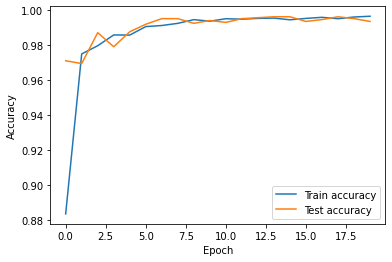

In [19]:
trained_model = train_model("./checkpoints3/", device, model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=20)

From the training we can see that we achieve a validation accuracy of around 0.996, which is quite good for this simple model. In fact the accuracy seems to stabilize after only 10 epochs.

## Visualizing a few results

In [20]:
def visualize_model(model, dataloaders, class_names, device, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        inputs,labels = next(iter(dataloaders['val']))
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for j in range(inputs.size()[0]):
          images_so_far += 1
          ax = plt.subplot(num_images//2, 2, images_so_far)
          ax.axis('off')
          ax.set_title('predicted: {}'.format(class_names[preds[j]]))
          plt.imshow(inputs.cpu().data[j,0,:,:], cmap='gray')

          if images_so_far == num_images:
            break

## Digits and their classifications

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


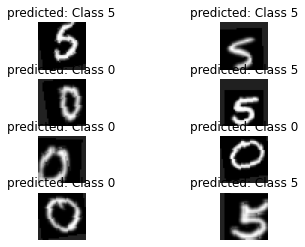

In [21]:
visualize_model(trained_model, dataloaders, class_names, device, 8)

Now, considering the digit 0 as the negative class and the digit 5 as the positive class, we obtain the following confusion matrix, showing a very similar small amount of false positives and false negatives. It is worth noting that the classes are umbalanced.

In [22]:
with torch.no_grad():
    FN = 0
    FP = 0
    TP = 0
    TN = 0

    for inputs, labels in dataloaders['val']:
      # inputs,labels = next(iter(dataloaders['val']))
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = trained_model(inputs)
      _, preds = torch.max(outputs, 1)

      for index,label in enumerate(labels):
        if label == 0:
          if preds[index] == label:
            TN += 1
          else:
            FN += 1
            # print(f'Pred: {preds[i]}, label: {label}')
        else:
          if preds[index] == label:
            TP += 1
          else:
            FP += 1

print(f'FP:{FP}, FN: {FN}, TP: {TP}, TN: {TN}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


FP:7, FN: 1, TP: 885, TN: 979


In [23]:
acc = TP/(TP+FP)
prec = (TP + TN)/(TP+FP+TN+FN)
recall = TP/(TP+FN)
f1_score = (2*recall*prec)/(recall+prec)

print(f'Accuracy: {acc}, Precision: {prec}, Recall rate: {recall}, F1-Score: {f1_score}')

Accuracy: 0.992152466367713, Precision: 0.9957264957264957, Recall rate: 0.9988713318284425, F1-Score: 0.9972964345824225


# Conclusion

The classifier seems well adapted to evaluate handwritten digits from the MNIST database. However, a better evaluation could be performed with more data augmention since the evaluation samples are not many, even a K-Fold cross-validation could be considered.
Moreover, the results could be tested with other databases that extend MNIST such as EMNIST or QMNIST, or could be even tested with pictures taken from an user`s handwritting.
For achieving an even greater precision, it would be possible to use deeper networks, specially in the classifier that is composed of a single FCL. More complex model could also be used by Transfer Learning, which is one of the most employed methods nowadays and that has shown very positive results lately as reported by the original creators of the MNIST database. 